# Introduction to Dask

In this notebook, we'll learn how to use [Dask](https://dask.org) for reading data from Azure.

The main [dask](https://github.com/dask/dask) and [distributed](https://github.com/dask/distributed) themselves are small and focused. Thousands of tools, some built by the Dask organization and most not, utilize Dask for parallel or distributed processing. Some of the most useful for data science include:

- https://github.com/dask/dask-ml
- https://github.com/dask/dask-kubernetes
- https://github.com/dask/dask-cloudprovider
- https://github.com/dask/dask-mpi
- https://github.com/dask/adlfs
- https://github.com/pydata/xarray
- https://github.com/dmlc/xgboost
- https://github.com/dask/dask-lightgbm
- https://github.com/rapidsai/cudf
- https://github.com/rapidsai/cuml

## Install required packages

In [ ]:
!pip install --upgrade dask distributed bokeh adlfs fsspec fastparquet pyarrow python-snappy lz4

## Get AML Workspace

You can use the AML workspace to retrieve datastores and keyvaults for accessing data credentials securely.

In [1]:
from azureml.core import Workspace

ws = Workspace.from_config()
ws

Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (azure-mgmt-keyvault 8.0.0 (/Users/cody/miniconda3/envs/dkdc/lib/python3.8/site-packages), Requirement.parse('azure-mgmt-keyvault<7.0.0,>=0.40.0')).


Workspace.create(name='default', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='azureml-examples')

## Create a distributed client

The [client](https://distributed.dask.org/en/latest/client.html) is the primary entrypoint for parallel processing with Dask. Calling it without inputs will create a local distributed scheduler, utilizing all the CPUs and cores on your machine. This can be useful for faster processing of larger in memory dataframes, or even computations on out of memory (OOM) data. 

When your local machine isn't powerful enough, you can provision a larger VM in Azure - the M series has 100+ CPUs and TBs of RAM. If this still isn't powerful enough, you can create a distributed Dask cluster on most hardware - see [the Dask setup guide](https://docs.dask.org/en/latest/setup.html) for details.

If you still need acceleration, [RAPIDSAI](https://github.com/rapidsai) further extends the PyData APIs on GPUs.

**Make sure you check out the dashboard!**

In [2]:
from distributed import Client

c = Client()
c.restart()
c

<Client: 'tcp://127.0.0.1:62124' processes=3 threads=6, memory=68.72 GB>

## Reading cloud data

Reading data from the cloud is as easy as reading it locally! Sorta!

### Pandas

You can read directly into Pandas from most cloud storage, with a notable exception - from the [`pandas.read_csv` documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html?highlight=read_csv#pandas-read-csv):

> Any valid string path is acceptable. The string could be a URL. Valid URL schemes include http, https, ftp, s3, gs, and file.

### Pythonic Filesystem for Azure

Fortunately, similar protocols have been developed for Azure storage in the [ADLFS](https://github.com/dask/adlfs) package, including:

- `az` or `abfs` for Azure Data Lake Storage Gen2 (ADLSv2) and Blob
- `adl` for Azure Data Lake Storage Gen1 (ADLSv1)

These are included in Python's `fsspec`. You can use the protocol directly in Dask and convert to Pandas for now.


In [3]:
import pandas as pd
import dask.dataframe as dd

from adlfs import AzureBlobFileSystem

In [4]:
# for single files in public blobs, you can use the https protocol and read directly into Pandas
df = pd.read_csv(
    "https://azuremlexamples.blob.core.windows.net/datasets/iris.csv"
)
df.head()

sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

In [5]:
# the same with Dask
df = dd.read_csv(
    "https://azuremlexamples.blob.core.windows.net/datasets/iris.csv"
)
df.head()

sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

In [6]:
# alternative syntax in Dask
storage_options = {"account_name": "azuremlexamples"}
df = dd.read_csv(f"az://datasets/iris.csv", storage_options=storage_options)
df.head()

sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

## Why use Dask?

Those all did the same thing...so why use Dask? There are a few scenarios:

- reading multiple files 
- reading private data from Azure with credentials
- reading directly into GPUs (with [cuDF](https://github.com/rapidsai/cudf))

You can also use the classes implemented in `adlfs` to query for files, depending on permissions.

To provide your own credentials, refer to the `adlfs` documentation for details - generally you can retrieve credentials from the workspace's datastore:

```python
import dask.dataframe as dd
from azureml.core import Workspace

ws = Workspace.from_config()
ds = ws.get_default_datastore() # ws.datastores["my-datastore-name"]

storage_options = {
    "account_name": ds.account_name,
    "account_key": ds.account_key,
}

df = dd.read_parquet(f"az://{ds.container_name}/path/to/data/*.parquet", storage_options=storage_options)
```

The basics are demonstrated below on public data.

In [7]:
container_name = "nyctlc"

storage_options = {"account_name": "azureopendatastorage"}

In [8]:
fs = AzureBlobFileSystem(**storage_options)
fs

In [9]:
fs.ls(f"{container_name}")

['nyctlc/_$azuretmpfolder$/',
 'nyctlc/backup/',
 'nyctlc/fhv',
 'nyctlc/fhv/',
 'nyctlc/green',
 'nyctlc/green/',
 'nyctlc/yellow',
 'nyctlc/yellow/']

In [10]:
fs.ls(f"{container_name}/green")

['nyctlc/green',
 'nyctlc/green/_SUCCESS',
 'nyctlc/green/_committed_316684848117331852',
 'nyctlc/green/puYear=2008',
 'nyctlc/green/puYear=2008/',
 'nyctlc/green/puYear=2009',
 'nyctlc/green/puYear=2009/',
 'nyctlc/green/puYear=2010',
 'nyctlc/green/puYear=2010/',
 'nyctlc/green/puYear=2012',
 'nyctlc/green/puYear=2012/',
 'nyctlc/green/puYear=2013',
 'nyctlc/green/puYear=2013/',
 'nyctlc/green/puYear=2014',
 'nyctlc/green/puYear=2014/',
 'nyctlc/green/puYear=2015',
 'nyctlc/green/puYear=2015/',
 'nyctlc/green/puYear=2016',
 'nyctlc/green/puYear=2016/',
 'nyctlc/green/puYear=2017',
 'nyctlc/green/puYear=2017/',
 'nyctlc/green/puYear=2018',
 'nyctlc/green/puYear=2018/',
 'nyctlc/green/puYear=2019',
 'nyctlc/green/puYear=2019/',
 'nyctlc/green/puYear=2020',
 'nyctlc/green/puYear=2020/',
 'nyctlc/green/puYear=2030',
 'nyctlc/green/puYear=2030/',
 'nyctlc/green/puYear=2081',
 'nyctlc/green/puYear=2081/']

In [33]:
fs.ls(f"{container_name}/green/puYear=2016/")

['nyctlc/green/puYear=2016',
 'nyctlc/green/puYear=2016/puMonth=1',
 'nyctlc/green/puYear=2016/puMonth=1/',
 'nyctlc/green/puYear=2016/puMonth=10',
 'nyctlc/green/puYear=2016/puMonth=10/',
 'nyctlc/green/puYear=2016/puMonth=11',
 'nyctlc/green/puYear=2016/puMonth=11/',
 'nyctlc/green/puYear=2016/puMonth=12',
 'nyctlc/green/puYear=2016/puMonth=12/',
 'nyctlc/green/puYear=2016/puMonth=2',
 'nyctlc/green/puYear=2016/puMonth=2/',
 'nyctlc/green/puYear=2016/puMonth=3',
 'nyctlc/green/puYear=2016/puMonth=3/',
 'nyctlc/green/puYear=2016/puMonth=4',
 'nyctlc/green/puYear=2016/puMonth=4/',
 'nyctlc/green/puYear=2016/puMonth=5',
 'nyctlc/green/puYear=2016/puMonth=5/',
 'nyctlc/green/puYear=2016/puMonth=6',
 'nyctlc/green/puYear=2016/puMonth=6/',
 'nyctlc/green/puYear=2016/puMonth=7',
 'nyctlc/green/puYear=2016/puMonth=7/',
 'nyctlc/green/puYear=2016/puMonth=8',
 'nyctlc/green/puYear=2016/puMonth=8/',
 'nyctlc/green/puYear=2016/puMonth=9',
 'nyctlc/green/puYear=2016/puMonth=9/']

In [34]:
files = fs.glob(f"{container_name}/green/puYear=2016/puMonth=*/*.parquet")
files = [f"az://{file}" for file in files]
files[-5:]

['az://nyctlc/green/puYear=2016/puMonth=5/part-00044-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2614-1.c000.snappy.parquet',
 'az://nyctlc/green/puYear=2016/puMonth=6/part-00108-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2678-1.c000.snappy.parquet',
 'az://nyctlc/green/puYear=2016/puMonth=7/part-00020-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2590-2.c000.snappy.parquet',
 'az://nyctlc/green/puYear=2016/puMonth=8/part-00172-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2742-2.c000.snappy.parquet',
 'az://nyctlc/green/puYear=2016/puMonth=9/part-00076-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2646-1.c000.snappy.parquet']

In [13]:
%%time
ddf = dd.read_parquet(
    files, storage_options=storage_options
).repartition(npartitions=16)
ddf

CPU times: user 8.39 s, sys: 585 ms, total: 8.97 s
Wall time: 1min 30s


Dask DataFrame Structure:
               vendorID lpepPickupDatetime lpepDropoffDatetime passengerCount tripDistance puLocationId doLocationId pickupLongitude pickupLatitude dropoffLongitude dropoffLatitude rateCodeID storeAndFwdFlag paymentType fareAmount    extra   mtaTax improvementSurcharge tipAmount tollsAmount ehailFee totalAmount tripType
npartitions=16                                                                                                                                                                                                                                                                                                                   
                  int32     datetime64[ns]      datetime64[ns]          int32      float64       object       object         float64        float64          float64         float64      int32          object       int32    float64  float64  float64               object   float64     float64  float64     float64    int32
                    ...                ...                 ...            ...          ...          ...          ...             ...            ...              ...             ...        ...             ...         ...        ...      ...      ...                  ...       ...         ...      ...         ...      ...
...                 ...                ...                 ...            ...          ...          ...          ...             ...            ...              ...             ...        ...             ...         ...        ...      ...      ...                  ...       ...         ...      ...         ...      ...
                    ...                ...                 ...            ...          ...          ...          ...             ...            ...              ...             ...        ...             ...         ...        ...      ...      ...                  ...       ...         ...      ...         ...      ...
                    ...                ...                 ...            ...          ...          ...          ...             ...            ...              ...             ...        ...             ...         ...        ...      ...      ...                  ...       ...         ...      ...         ...      ...
Dask Name: repartition, 172 tasks

In [14]:
ddf = ddf.persist()  # persist all or some of data in RAM

In [15]:
%%time
len(ddf)

CPU times: user 10.3 s, sys: 1.06 s, total: 11.3 s
Wall time: 4min 26s


1224158

In [16]:
%%time
len(ddf)

CPU times: user 21.5 ms, sys: 2.4 ms, total: 23.9 ms
Wall time: 43.2 ms


1224158

In [24]:
ddf.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 23 entries, vendorID to tripType
dtypes: datetime64[ns](2), object(4), float64(12), int32(5)

In [ ]:
%%time
ddf.describe().compute()

CPU times: user 126 ms, sys: 19 ms, total: 145 ms
Wall time: 163 ms


<AxesSubplot:>

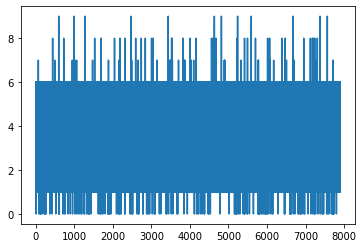

In [31]:
%%time
ddf["passengerCount"].compute().plot()

In [32]:
%%time
gbs = round(ddf.memory_usage(index=True, deep=True).sum().compute() / 1e9, 2)
print(f"ddf is {gbs} GBs")

ddf is 0.46 GBs
CPU times: user 58.9 ms, sys: 4.72 ms, total: 63.6 ms
Wall time: 223 ms
